# dat-A: Characterize Sequences and Repair Genotypes
dat-A in this study refers to the set of repair outcomes observed in PostCas-Unspliced, their repair genotypes, their frequencies, and their associated gRNA. The code here extracts these information.

See also 'inDelphi_Evaluation.ipynb' for final postprocessing and dat-A table export.

In [1]:
from config import *
from utils import *

import re
import copy
import numpy as np
import collections
import multiprocessing
import pickle

from tqdm.notebook import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
bc_grna_precas_map = load_bc_seq(BC_GRNA_PRECAS_MAP)
bc_grna1_postcas_map = load_bc_seq(BC_GRNA1_POSTCAS_MAP)
bc_grna2_postcas_map = load_bc_seq(BC_GRNA2_POSTCAS_MAP)

bc_unspliced_precas_map = load_bc_seq(BC_UNSPLICED_PRECAS_MAP)
bc_unspliced1_postcas_map = load_bc_seq(BC_UNSPLICED1_POSTCAS_MAP)
bc_unspliced2_postcas_map = load_bc_seq(BC_UNSPLICED2_POSTCAS_MAP)

bc_spliced_precas_map = load_bc_seq(BC_SPLICED_PRECAS_MAP)
bc_spliced1_postcas_map = load_bc_seq(BC_SPLICED1_POSTCAS_MAP)
bc_spliced2_postcas_map = load_bc_seq(BC_SPLICED2_POSTCAS_MAP)

## Map Sequences to Design Library IDs
We have previously constructed barcode:(sequence:counts) lookup tables (see Barcode_Sequence_Lookup_Tables.ipynb).
But for a given sequence, what is the designed sequence? E.g. given a target sequence with indels after repair, what is the designed target sequence? Given a gRNA sequence, what is the designed gRNA ID in the library?

In short, for a query sequence Q, we find the most similar designed sequence D from lib-SA. This is done by computing the Dice Coefficient between Q and D, using 5-mers, and picking the D that is most similar to Q. After doing this for all sequences, we can convert our barcode:{sequence:counts} lookup tables to barcode:{design_id:counts} lookup tables.

We also discard anything that doesn't make sense. In particular, for a target sequence and gRNA sequence with the same barcode, if their designed versions do not pair (i.e. the designed gRNA doesn't target the designed target sequence), then we discard them from the lookup tables. This can happen due to sequencing errors in the barcodes, or some other systematic error.

In the code, we call the designed gRNA ID as 'gid', and the designed target sequence ID as 'tid'.

In [3]:
def get_gid(obs_g):
    if obs_g in exp_grna_gid_map:
        return exp_grna_gid_map[obs_g][0], 0
    
    # Since obs_g is always len 19 or 20, we can use hamming distance
    min_distance = float('inf')
    best_design_gid = None
    for design_g in exp_grna_gid_map:
        if len(design_g) == len(obs_g):
            distance = hamming_distance(design_g, obs_g)
        else:
            minlen, minseq = min((len(design_g), design_g), (len(obs_g), obs_g))
            maxlen, maxseq = max((len(design_g), design_g), (len(obs_g), obs_g))
            distance = min(hamming_distance(minseq, maxseq[0:minlen]),
                           hamming_distance(minseq, maxseq[1:minlen + 1]))
        if distance < min_distance:
            min_distance = distance
            best_design_gid, _ = exp_grna_gid_map[design_g]
    return best_design_gid, min_distance


def generate_bc_gid_map(bc_obs_g_map):
    try:
        p = multiprocessing.Pool(NUM_PROCESSES)

        bc_design_gid_map = collections.defaultdict(lambda: collections.defaultdict(int))

        obs_gs = list({obs_g for bc in tqdm(bc_obs_g_map) for obs_g in bc_obs_g_map[bc]})
        design_gids = []
        for design_gid, distance in tqdm(p.imap(get_gid, obs_gs, chunksize=1), total=len(obs_gs)):
            design_gids.append(design_gid)

        obs_design_gid_map = {obs_g:design_gids[i] for i, obs_g in enumerate(obs_gs)}

        for bc in tqdm(bc_obs_g_map):
            for obs_g in bc_obs_g_map[bc]:
                bc_design_gid_map[bc][obs_design_gid_map[obs_g]] += bc_obs_g_map[bc][obs_g]

        print('Num Unique BCs:', len(bc_obs_g_map))
        print('(Before) Num Unambiguous BCs:', sum(len(bc_obs_g_map[bc]) == 1 for bc in bc_obs_g_map))
        print('(After) Num Unambiguous BCs:', sum(len(bc_design_gid_map[bc]) == 1 for bc in bc_design_gid_map))
    finally:
        p.close()
        p.join()
    
    return bc_design_gid_map

### Map Barcode-gRNA to Barcode-gid

In [4]:
# Output Dictionary format {bc: {gid: count}}

if not pickle_exists(BC_GID_PRECAS_MAP):
    bc_gid_precas_map = generate_bc_gid_map(bc_grna_precas_map)
    save_bc_seq(bc_gid_precas_map, BC_GID_PRECAS_MAP)
else:
    bc_gid_precas_map = load_bc_seq(BC_GID_PRECAS_MAP)

    
if not pickle_exists(BC_GID1_POSTCAS_MAP):
    bc_gid1_postcas_map = generate_bc_gid_map(bc_grna1_postcas_map)
    save_bc_seq(bc_gid1_postcas_map, BC_GID1_POSTCAS_MAP)
else:
    bc_gid1_postcas_map = load_bc_seq(BC_GID1_POSTCAS_MAP)

    
if not pickle_exists(BC_GID2_POSTCAS_MAP):
    bc_gid2_postcas_map = generate_bc_gid_map(bc_grna2_postcas_map)
    save_bc_seq(bc_gid2_postcas_map, BC_GID2_POSTCAS_MAP)
else:
    bc_gid2_postcas_map = load_bc_seq(BC_GID2_POSTCAS_MAP)

### Map Barcode-Target (PreCas Unspliced) to Barcode-gid

In [5]:
K = 5
design_t_kmers_map = {design_t:kmers(design_t, K) for design_t in exp_target_tid_map}

def get_tid(obs_t):
    if obs_t in exp_target_tid_map:
        return exp_target_tid_map[obs_t], 1
    
    max_sim = -float('inf')
    best_design_tid = None
    for design_t in exp_target_tid_map:
        if design_t in obs_t or obs_t in design_t:
            return exp_target_tid_map[design_t], 1
        
        sim = dice_coefficient(obs_t, design_t_kmers_map[design_t], K)
        if sim > max_sim:
            max_sim = sim
            best_design_tid = exp_target_tid_map[design_t]
    return best_design_tid, max_sim


def generate_bc_tid_map(bc_obs_t_map):
    try:
        p = multiprocessing.Pool(NUM_PROCESSES)

        bc_design_tid_map = collections.defaultdict(lambda: collections.defaultdict(int))

        obs_ts = list({obs_t for bc in tqdm(bc_obs_t_map) for obs_t in bc_obs_t_map[bc]})
        design_tids = []
        for design_tid, sim in tqdm(p.imap(get_tid, obs_ts, chunksize=1), total=len(obs_ts)):
            if sim < 0.3:
                design_tids.append(None)
            else:
                design_tids.append(design_tid)

        obs_designids_map = {obs_t:design_tids[i] for i, obs_t in enumerate(obs_ts)}

        for bc in tqdm(bc_obs_t_map):
            for obs_t in bc_obs_t_map[bc]:
                design_tid = obs_designids_map[obs_t]
                if design_tid is None:
                    continue
                bc_design_tid_map[bc][design_tid] += bc_obs_t_map[bc][obs_t]

        print("(Before) Num Unique BCs:", len(bc_obs_t_map))
        print("(Before) Num Unambiguous BCs:", sum(len(bc_obs_t_map[bc]) == 1 for bc in bc_obs_t_map))
        print("(After) Num Unique BCs:", len(bc_design_tid_map))
        print("(After) Num Unambiguous BCs:", sum(len(bc_design_tid_map[bc]) == 1 for bc in bc_design_tid_map))
    finally:
        p.close()
        p.join()

    return bc_design_tid_map


def bc_tid2gid_map(bc_tid_map):
    bc_gid_map = collections.defaultdict(lambda: collections.defaultdict(int))
    for bc in bc_tid_map:
        for tid in bc_tid_map[bc]:
            for gid in exp_tid_gids_map[tid]:
                bc_gid_map[bc][gid] += bc_tid_map[bc][tid]
    return bc_gid_map

In [6]:
# Output Dictionary format {bc: {tid: count}}
if not pickle_exists(BC_TID_UNSPLICED_PRECAS_MAP):
    bc_tid_unspliced_precas_map = generate_bc_tid_map(bc_unspliced_precas_map)
    save_bc_seq(bc_tid_unspliced_precas_map, BC_TID_UNSPLICED_PRECAS_MAP)
else:
    bc_tid_unspliced_precas_map = load_bc_seq(BC_TID_UNSPLICED_PRECAS_MAP)

In [7]:
# Output Dictionary format {bc: {gid: count}}
if not pickle_exists(BC_GID_UNSPLICED_PRECAS_MAP):
    bc_gid_unspliced_precas_map = bc_tid2gid_map(bc_tid_unspliced_precas_map)
    save_bc_seq(bc_gid_unspliced_precas_map, BC_GID_UNSPLICED_PRECAS_MAP)
else:
    bc_gid_unspliced_precas_map = load_bc_seq(BC_GID_UNSPLICED_PRECAS_MAP)

## Identify and Characterize Repair Genotypes (indels)
At this point, for a given observed target sequence (with indels due to repair), we know the original target sequence (as designed). We need to now characterize the indels.

For example, say the target sequence is AGTC|AGTC, with | signifying the Cas9+gRNA cutsite. The observed sequence is AGT-|--TC, '-' meaning deletions. We can describe this indel by deletion size and starting position, i.e. in this example, the indel has a deletion size of 3, and genotype position of 1 to the left of the cutsite. Another example: AGTC|--TC, deletion size is 2, genotype position is 0.

### Map Barcode-Target (PostCas Unspliced) to Barcode-tid-indel

In [8]:
def determine_product_type(tid_san_obs_t):
    tid, san_obs_t = tid_san_obs_t    
    design_t = exp_tid_target_map[tid]
    no_indel_payload = [(design_t, 'N')]
    cryptic_deletion_payload = [(san_obs_t, 'CD')]
    cryptic_insertion_payload = [(san_obs_t, 'CI')]
    cryptic_payload = [(san_obs_t, 'C')]
    
    HAM_DIST_THRES = 3
    
    # Classify as not an indel (wt) with leeway
    if san_obs_t == design_t or san_obs_t in design_t or design_t in san_obs_t:
        return no_indel_payload
    
    if len(san_obs_t) == len(design_t) and hamming_distance(san_obs_t, design_t) <= HAM_DIST_THRES:
        return no_indel_payload
    
    if len(san_obs_t) < len(design_t) and hamming_distance(san_obs_t, design_t[0:len(san_obs_t)]) <= HAM_DIST_THRES:
        return no_indel_payload
    
    if len(san_obs_t) > len(design_t) and hamming_distance(san_obs_t[0:len(design_t)], design_t) <= HAM_DIST_THRES:
        return no_indel_payload
    
    # Deletion around cutsite? If so, figure out deletion size and position
    if len(san_obs_t) < len(design_t):
        deletion_size = len(design_t) - len(san_obs_t)
        if deletion_size > MAX_INDEL_LEN:
            return cryptic_deletion_payload
        
        simulations = []
        min_distance = float('inf')
        cutsites = get_cutsites(tid)
        for cutsite in cutsites:            
            for genotype_pos, simulated_product in generate_product(design_t, cutsite, deletion_size):
                distance = hamming_distance(simulated_product, san_obs_t)
                
                if distance < min_distance:
                    min_distance = distance
                    simulations.append((min_distance, (simulated_product, genotype_pos, cutsite)))
        if len(simulations) > 0 and min_distance <= HAM_DIST_THRES:
            candidates = []
            while simulations and simulations[-1][0] == min_distance:
                simulated_product, genotype_pos, cutsite = simulations.pop()[1]
                a = max(0, cutsite + genotype_pos - deletion_size - 3)
                b = min(cutsite + genotype_pos - deletion_size + 3, len(simulated_product))
                if simulated_product[a:b] == san_obs_t[a:b]:
                    candidates.append((san_obs_t, 'D', deletion_size, genotype_pos, cutsite))
                
            if len(candidates) > 0:
                return candidates
        
        return cryptic_deletion_payload
    
    # Insertion around cutsite? If so, figure out its identity
    elif len(san_obs_t) > len(design_t):
        cutsites = get_cutsites(tid)
        for cutsite in cutsites:
            prefix, suffix = design_t[5:cutsite], design_t[cutsite:-5]
            prog = re.compile(prefix + '.+' + suffix)
            m = prog.search(san_obs_t)
            if m is not None:
                insertion_start, insertion_end = m.start() + len(prefix), m.end() - len(suffix)
                insertion_genotype = san_obs_t[insertion_start:insertion_end]
                return [(san_obs_t, 'I', len(insertion_genotype), insertion_genotype, cutsite)]
        return cryptic_insertion_payload
    
    # len(san_obs_t) == len(design_t) at this point.
    # These have deletes AND inserts, and many of these are far from cutsites,
    # so are likely sequencing errors or something.
    # Ignore these; there aren't that many anyway.
    return cryptic_payload


def get_tid_indel(obs_t):
    if obs_t in exp_target_tid_map:
        return exp_target_tid_map[obs_t], 1
    
    max_sim = -float('inf')
    best_design_tid = None
    for design_t in exp_target_tid_map:
        if design_t in obs_t or obs_t in design_t:
            return exp_target_tid_map[design_t], 1
        
        sim = dice_coefficient(obs_t, design_t_kmers_map[design_t], K)
        if sim > max_sim:
            expected_sim = expected_dice_coefficient(len(design_t), len(obs_t), K)
            if sim > expected_sim:
                max_sim = sim
                best_design_tid = exp_target_tid_map[design_t]
    return best_design_tid, max_sim


def _corroborate_indel(bc, tid, indels):
    real_indels = []
    other_indels = []
    
    for indel in indels:
        if indel[1] == 'D' or indel[1] == 'I':
            real_indels.append(indel)
        else:
            other_indels.append(indel)
    
    if len(real_indels) == 1:
        san_obs_t, product_type, a, b, cutsite = real_indels[0]
        return [(san_obs_t, product_type + 'S', a, b, cutsite)] + other_indels
    
    # Look up BC in bc_gid_unspliced_precas_map and see if the gid and query tid/indel makes sense
    obs_gids = set()
    if bc in bc_gid_precas_map:
        for gid in bc_gid_precas_map[bc]:
            obs_gids.add(gid)
    if bc in bc_gid1_postcas_map:
        for gid in bc_gid1_postcas_map[bc]:
            obs_gids.add(gid)
    if bc in bc_gid2_postcas_map:
        for gid in bc_gid2_postcas_map[bc]:
            obs_gids.add(gid)
            
    if len(obs_gids) == 0 or bc not in bc_gid_unspliced_precas_map:
        return indels
    
    candidate_gids = obs_gids & bc_gid_unspliced_precas_map[bc].keys()
    if len(candidate_gids) == 0:
        return indels
    
    marked_real_indels = []
    for indel in real_indels:
        added = False
        cutsite = indel[-1]
        for gid in exp_tid_gids_map[tid]:
            design_t = exp_tid_target_map[tid]
            grna = exp_gid_grna_map[gid]
            g_orientation = exp_grna_gid_map[grna][1]
            if cutsite == get_cutsite(grna, design_t, g_orientation) and gid in candidate_gids:
                san_obs_t, product_type, a, b, cutsite = indel
                marked_real_indels.append((san_obs_t, product_type + 'S', a, b, cutsite))
                added = True
        if not added:
            marked_real_indels.append(indel)
    return marked_real_indels + other_indels


def generate_bc_tid_indel_map(bc_t_postcas_map):
    try:
        p = multiprocessing.Pool(NUM_PROCESSES)

        bc_tid_san_t_map = collections.defaultdict(lambda: collections.defaultdict(int))
        bc_tid_indel_map = collections.defaultdict(lambda: collections.defaultdict(lambda: collections.defaultdict(int)))

        obs_ts = list({obs_t for bc in tqdm(bc_t_postcas_map) for obs_t in bc_t_postcas_map[bc]})
        tid_san_obs_ts = []
        i = 0
        for design_tid, sim in tqdm(p.imap(get_tid_indel, obs_ts, chunksize=1), total=len(obs_ts)):
            if design_tid is not None:
                design_t = exp_tid_target_map[design_tid]
                san_obs_t = sanitize_postcas_unspliced(obs_ts[i], design_t)
                tid_san_obs_ts.append((design_tid, san_obs_t))
            else:
                tid_san_obs_ts.append(None)
            i += 1
                
        obs_tid_san_map = {obs_t:tid_san_obs_ts[i] for i, obs_t in enumerate(obs_ts)}
        
        for bc in tqdm(bc_t_postcas_map):
            for obs_t in bc_t_postcas_map[bc]:
                tid_san_obs_t = obs_tid_san_map[obs_t]
                if tid_san_obs_t is not None:
                    bc_tid_san_t_map[bc][obs_tid_san_map[obs_t]] += bc_t_postcas_map[bc][obs_t]
                
        tid_san_ts = list({tid_san for bc in tqdm(bc_tid_san_t_map) for tid_san in bc_tid_san_t_map[bc]})
        tid_indels = []
        for r in tqdm(p.imap(determine_product_type, tid_san_ts, chunksize=1), total=len(tid_san_ts)):
            tid_indels.append(r)
            
        tid_san_tid_indel_map = {tid_san:tid_indels[i] for i, tid_san in enumerate(tid_san_ts)}
            
        for bc in tqdm(bc_tid_san_t_map):
            for tid_san_t in bc_tid_san_t_map[bc]:
                tid, _ = tid_san_t
                
                indels = _corroborate_indel(bc, tid, tid_san_tid_indel_map[tid_san_t])
                for tid_indel in indels:
                    bc_tid_indel_map[bc][tid][tid_indel] += bc_tid_san_t_map[bc][tid_san_t]
        
    finally:
        p.close()
        p.join()
        
    print('(Before) Num Unique BCs:', len(bc_t_postcas_map))
    print('(After) Num Unique BCs:', len(bc_tid_indel_map))

    return bc_tid_indel_map


def bc_tidindel2_gidindel_map(bc_tid_indel_map):
    bc_gid_indel_map = collections.defaultdict(lambda: collections.defaultdict(lambda: collections.defaultdict(int)))
    for bc in tqdm(bc_tid_indel_map):
        for tid in bc_tid_indel_map[bc]:
            for indel in bc_tid_indel_map[bc][tid]:
                if 'C' in indel[1] or 'N' in indel[1]:
                    for gid in exp_tid_gids_map[tid]:
                        bc_gid_indel_map[bc][gid][indel] += bc_tid_indel_map[bc][tid][indel]
                else:
                    cutsite = indel[-1]
                    for gid in exp_tid_gids_map[tid]:
                        design_t = exp_tid_target_map[tid]
                        grna = exp_gid_grna_map[gid]
                        g_orientation = exp_grna_gid_map[grna][1]
                        if cutsite == get_cutsite(grna, design_t, g_orientation):
                            bc_gid_indel_map[bc][gid][indel] += bc_tid_indel_map[bc][tid][indel]
    return bc_gid_indel_map

In [9]:
# Output Dictionary format {bc: {tid: {indel: count}}}
if not pickle_exists(BC_TID_INDEL_POSTCAS_MAP):
    bc_tid1_indel_postcas_map = generate_bc_tid_indel_map(bc_unspliced1_postcas_map)

In [10]:
# Output Dictionary format {bc: {tid: {indel: count}}}
if not pickle_exists(BC_TID_INDEL_POSTCAS_MAP):
    bc_tid2_indel_postcas_map = generate_bc_tid_indel_map(bc_unspliced2_postcas_map)

In [11]:
def merge_bc_tid_indel_maps(bc_tid1_indel_map, bc_tid2_indel_map):
    bc_tid_indel_map = collections.defaultdict(lambda: collections.defaultdict(lambda: collections.defaultdict(int)))
    
    merged = 0
    for bc in tqdm(bc_tid1_indel_map.keys() & bc_tid2_indel_map.keys()):
        for tid in (bc_tid1_indel_map[bc].keys() & bc_tid2_indel_map[bc].keys()):
            for indel in (bc_tid1_indel_map[bc][tid].keys() & bc_tid2_indel_map[bc][tid].keys()):
                bc_tid_indel_map[bc][tid][indel] += np.mean([bc_tid1_indel_map[bc][tid][indel], bc_tid2_indel_map[bc][tid][indel]])
                merged += 1
    
    for bc in tqdm(bc_tid1_indel_map):
        for tid in bc_tid1_indel_map[bc]:
            for indel in bc_tid1_indel_map[bc][tid]:
                if not (bc in bc_tid_indel_map and tid in bc_tid_indel_map[bc] and indel in bc_tid_indel_map[bc][tid]):
                    bc_tid_indel_map[bc][tid][indel] += bc_tid1_indel_map[bc][tid][indel]
    for bc in tqdm(bc_tid2_indel_map):
        for tid in bc_tid2_indel_map[bc]:
            for indel in bc_tid2_indel_map[bc][tid]:
                if not (bc in bc_tid_indel_map and tid in bc_tid_indel_map[bc] and indel in bc_tid_indel_map[bc][tid]):
                    bc_tid_indel_map[bc][tid][indel] += bc_tid2_indel_map[bc][tid][indel]
    
    print("Num Common Indels:", merged)
    return bc_tid_indel_map

In [12]:
# Output Dictionary format {bc: {tid: {indel: count}}}
if not pickle_exists(BC_TID_INDEL_POSTCAS_MAP):
    # PostCas replicate data are merged for larger power
    bc_tid_indel_postcas_map = merge_bc_tid_indel_maps(bc_tid1_indel_postcas_map, bc_tid2_indel_postcas_map)
    save_bc_id_indel(bc_tid_indel_postcas_map, BC_TID_INDEL_POSTCAS_MAP)
else:
    bc_tid_indel_postcas_map = load_bc_seq(BC_TID_INDEL_POSTCAS_MAP)

In [13]:
# Output Dictionary format {bc: {gid: {indel: count}}}
if not pickle_exists(BC_GID_INDEL_POSTCAS_MAP):
    bc_gid_indel_postcas_map = bc_tidindel2_gidindel_map(bc_tid_indel_postcas_map)
    save_bc_id_indel(bc_gid_indel_postcas_map, BC_GID_INDEL_POSTCAS_MAP)
else:
    bc_gid_indel_postcas_map = load_bc_seq(BC_GID_INDEL_POSTCAS_MAP)

### Compute Empirical Indel Distribution
We tabulate all the observed repair genotypes and their counts for a given designed gRNA/Target pair. We normalize the counts to yield repair frequencies.

In [14]:
def determine_postcas_product_distribution():
    gt_indel_dist_map = collections.defaultdict(generate_empty_distribution)
    
    for bc in tqdm(bc_gid_indel_postcas_map):
        for gid in bc_gid_indel_postcas_map[bc]:
            for indel in bc_gid_indel_postcas_map[bc][gid]:
                if indel[1] in DELETION_SIGNATURES:
                    _, _, deletion_size, genotype_pos, cutsite = indel
                    tid = exp_gid_tid_map[gid]
                    design_t = exp_tid_target_map[tid]
                    grna = exp_gid_grna_map[gid]
                    g_orientation = exp_grna_gid_map[grna][1]
                    pair = (grna, design_t, g_orientation)
                    gt_indel_dist_map[pair][-deletion_size][genotype_pos] += bc_gid_indel_postcas_map[bc][gid][indel]
                elif indel[1] in INSERTION_SIGNATURES and indel[2] == 1:
                    _, _, _, inserted_base, cutsite =  indel
                    tid = exp_gid_tid_map[gid]
                    design_t = exp_tid_target_map[tid]
                    grna = exp_gid_grna_map[gid]
                    g_orientation = exp_grna_gid_map[grna][1]
                    pair = (grna, design_t, g_orientation)
                    gt_indel_dist_map[pair][1][inserted_base] += bc_gid_indel_postcas_map[bc][gid][indel]
    return gt_indel_dist_map

In [15]:
if not pickle_exists(UNNORM_GT_INDEL_DIST_MAP):
    unnorm_gt_indel_dist_map = determine_postcas_product_distribution()
    save_var(unnorm_gt_indel_dist_map, UNNORM_GT_INDEL_DIST_MAP)
else:
    unnorm_gt_indel_dist_map = load_var(UNNORM_GT_INDEL_DIST_MAP)

In [16]:
print(len(unnorm_gt_indel_dist_map))

3963


In [17]:
def plot_numproducts_distributions():
    num_products = []
    num_unique_products = []
    for gt in tqdm(unnorm_gt_indel_dist_map):
        distribution = unnorm_gt_indel_dist_map[gt]
        distribution_list, _ = distribution_to_list(distribution)
        total = float(sum(distribution_list))
        num_products.append(total)
        num_unique_products.append(sum(p > 0 for p in distribution_list))
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    sns.distplot(num_products, ax=ax[0])
    ax[0].set(xlabel='Num Products Observed', ylabel='Frequency', title='Distribution of Interpretable Reads per Guide/Target pair')
    sns.distplot(num_unique_products, ax=ax[1])
    ax[1].set(xlabel='Num Unique Products Observed', ylabel='Frequency', title='Distribution of Unique Products per Guide/Target pair')
    plt.show()

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


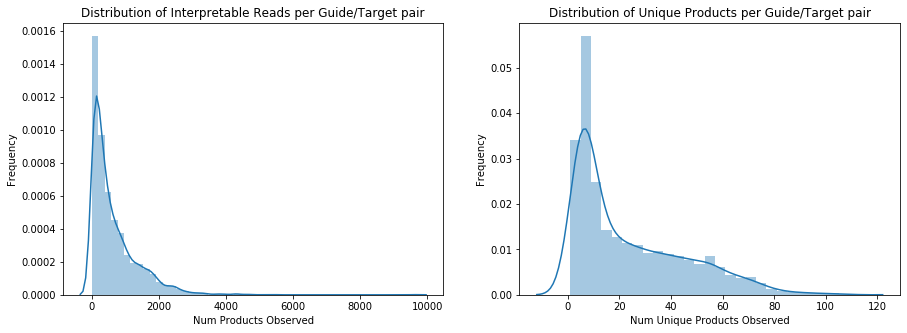

In [18]:
plot_numproducts_distributions()

In [19]:
if not pickle_exists(GT_INDEL_DIST_MAP):
    gt_indel_dist_map = copy.deepcopy(unnorm_gt_indel_dist_map)

    for gt in tqdm(gt_indel_dist_map):
        distribution = gt_indel_dist_map[gt]
        normalize_distribution(distribution)
    save_var(gt_indel_dist_map, GT_INDEL_DIST_MAP)
else:
    gt_indel_dist_map = load_var(GT_INDEL_DIST_MAP)

In [20]:
def plot_indel_types():
    deletions = 0
    insertions_1bp = 0
    insertions_multiplebp = 0
    combo_indels = 0
    
    tid_set = set()
    for bc in tqdm(bc_tid_indel_postcas_map):
        for tid in bc_tid_indel_postcas_map[bc]:
            for indel in bc_tid_indel_postcas_map[bc][tid]:
                count = bc_tid_indel_postcas_map[bc][tid][indel]
                if indel[1] == 'D' or indel[1] == 'DS':
                    deletions += count
                    tid_set.add(tid)
                elif indel[1] == 'I' or indel[1] == 'IS':
                    tid_set.add(tid)
                    if indel[2] == 1:
                        insertions_1bp += count
                    else:
                        insertions_multiplebp += count
                elif indel[1] == 'C':
                    tid_set.add(tid)
                    combo_indels += count

    d = [deletions, insertions_1bp, insertions_multiplebp, combo_indels]
    labels = ['Deletions', '1bp Insertions', '>1bp Insertion', 'Combo Indels']
    plt.pie(d, labels=labels, autopct='%1.1f%%')
    plt.title('Categories of Repair')
    plt.show()

### Figure 2A (before aesthetic augmentation)

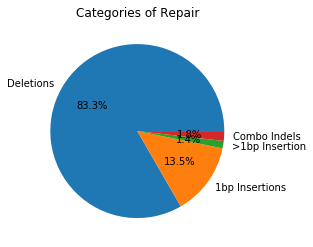

In [21]:
plot_indel_types()